In [339]:
# DEV SCRIPT - DO NOT USE
import gen_funcs as gf
import ranked_funcs as rf
import clump_funcs as cf
import plot_funcs as pf

import os
import numpy as np
import re
from scipy.linalg import norm

In [340]:
# Select desired figures
print("Running setup operations", flush=True)
selected_figs = ["old"]
# selected_figs = ["Fig2_Fig4", "Fig6", "Fig7", "Fig8"]

Running setup operations


In [341]:
# Load paths
path_paths = "paths.json"
dict_paths = gf.load_paths_all(path_paths)

(gen_funcs.load_paths_all)
	Reading paths


In [343]:
# Load data
path_data = dict_paths["path_data"]
paths_psliceout = gf.load_paths_psliceout(path_data, selected_figs)
data_all = gf.iteratively_load_data(paths_psliceout)

(gen_funcs.iteratively_load_data)
	Loading data
		Loading file ./data/old/psliceout_dm1e-2_c_br_n_5E14-5E13.dat


In [344]:
# Rank particles
path_ranked = dict_paths["path_ranked"]
n_neighbors = 100
fout_ranked = gf.iteratively_rank_neighbors(data_all, paths_psliceout, path_ranked, n_neighbors)

(gen_funcs.iteratively_rank_neighbors)
	Ranking particles
		Ranking file ./data/old/psliceout_dm1e-2_c_br_n_5E14-5E13.dat
(ranked_funcs.rank_neighbors)
	Checking if ranked file exists
		Ranked file ./output/ranked/ranked_100neigh_psliceout_dm1e-2_c_br_n_5E14-5E13.dat already exists. Skipping.


In [385]:
# Use ranked data to get COM coordinates
print("Using ranked data to get COM coordinates", flush=True)

# Calculate Roche density as threshold
G = 1
Omega_K = 1
H_g = 5.5
threshold_rho = cf.calculate_density_Roche(G, Omega_K, H_g)

# Get COM coordinates for all ranked files
# Setting up shell parameters
dr = 3e-4
n_shells = 5100
threshold_radius = 5.

# Do for all ranked files
data_rankedf = {}
coords_com_rankedf = {}
for folder in fout_ranked:
    for fin_ranked in fout_ranked[folder]:
        _fin_ranked = fin_ranked.split("/")[-1].strip(".dat")
        try:
            data_rankedf[_fin_ranked]
        except KeyError:
            # Consolidate raw data with ranked data
            data_key = re.search("ranked_[0-9]+neigh_(.+).dat", fin_ranked).group(1)
            raw_coords, raw_idx = data_all[data_key]['raw_coords'], data_all[data_key]['raw_idx']

            # Get ranked data
            _data_ranked_red, _data_ranked = rf.read_ranked(fin_ranked, threshold_rho)

            # Get COM coordinates
            _coords_com_ranked, idxs_clump, R_Hs_final = rf.get_com_coords(_data_ranked_red, dr, n_shells, raw_coords, raw_idx, threshold_radius, var_shell=False)

            # Remove the final "clump" since it would have been empty
            _coords_com_ranked = {key: _coords_com_ranked[key][:-1] for key in _coords_com_ranked}

            # Save data
            data_rankedf[_fin_ranked] = _data_ranked_red
            coords_com_rankedf[fin_ranked] = {"coords_com": _coords_com_ranked, "idxs_clump": idxs_clump, "R_Hs": R_Hs_final}

Using ranked data to get COM coordinates


(ranked_funcs.read_ranked)
	Reading in and reducing ranked file ./output/ranked/ranked_100neigh_psliceout_dm1e-2_c_br_n_5E14-5E13.dat
(ranked_funcs.get_com_coords)
	Finding centres of mass of disconnected clumps (threshold radius:  5.0)

			COM of clump 0: [ 2.35744e+00  3.30877e+01 -1.01090e-04]
			Number of particles in raw search space: 10000000
			Minimum distance to COM: 9.466442771204423e-07
			Number of particles in reduced search space: 451409
			Number of particles in preclump: 160303.0
			Indices: [2993 2994 2995]
			Crossing point: 2993
			Number of particles in postclump: 150870.0
			Number of particles in ranked data at the end: 6393847

			COM of clump 1: [-14.6494     10.7319     -0.0983921]
			Number of particles in raw search space: 451409
			Minimum distance to COM: 23.091053236615405
			Number of particles in reduced search space: 0
			No more particles in search space. Exiting.


In [386]:
_coords_com_ranked

{'idx': [2491952],
 'radius': [5.60808e-06],
 'x': [2.35744],
 'y': [33.0877],
 'z': [-0.00010109]}

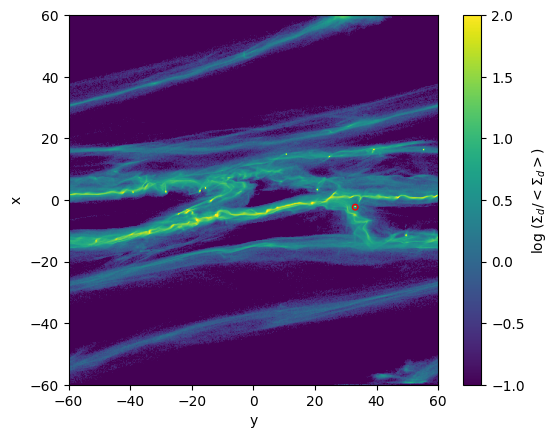

In [391]:
# Plotting
fin = "psliceout_dm1e-2_c_br_n_5E14-5E13"
# fin = "psliecout1"
plot_inst = pf.PlotDustSurfdensEff(data_all[fin], _coords_com_ranked, R_Hs_final)
plot_inst.plot_surfdens()